## Información no Estructurada
### Máster Universitario en Ciencia de Datos
# Práctica 3.4 &ndash; Recomendación: factorización de matrices y deep learning

### Autores: Iñigo Gómez Carvajal y Jon Zorrilla Gamboa

Esta práctica tiene por objetivo comprender el diseño de métodos de filtrado colaborativo mediante deep learning como transición desde un modelo bilineal típico de factorización de matrices hacia modelos neuronales de complejidad arbitraria.

El trabajo a realizar se secuencia en los siguiented pasos:
1. Filtrado colaborativo basado en factorización de matrices en NumPy.
2. Repetición del mismo método pero visto como modelo neuronal en TensorFlow o PyTorch (a elegir).
3. Ampliación del modelo introduciendo capas ocultas y/u otras variaciones.

Como punto de partida se plantea en cada caso la formulación de la factorización de matrices más sencilla posible.

Se proporciona gran parte del código; los dos primeros ejercicios consistirán en completar un esqueleto de código, y el tercero queda abierto a la dirección que el estudiante opte por seguir.

## 1.&nbsp; Procesamiento de datos

Se facilita una clase Ratings que se ocupa de las siguientes operaciones:
1. Lectura de datos de rating de un fichero.
2. Preparación de datos en forma de matriz (sin preocuparnos del gasto de RAM: podrían usarse implementaciones sparse matrix para un uso más frugal de RAM y soportar conjuntos de datos más grandes).
3. Binarización de los ratings.
4. Partición de datos en entrenamiento y test.
5. Duplicación redundante de los datos: matriz vs. data frame de ratings de entrenamiento, acorde con diferentes requisitos para diferentes frameworks de implementación (NumPy vs. TensorFlow / PyTorch).

Se hace una implementación simplificada y directa orientada a obtener lo suficiente para los ejercicios de esta práctica, sin buscar más generalidad. Por ejemplo, todas las operaciones (incluida la partición entrenamiento/test) se realizan en el constructor y no se implementan más funciones en la clase que las estrictamente necesarias para los ejercicios y pruebas. Igualmente decidimos trabajar con ratings binarizados.

Se proporcionan una líneas al final de la celda para ilustrar cómo quedan almacenados datos en diferentes subconjuntos y estructuras.

El conjunto de datos `ratings.dat` está disponible en https://grouplens.org/datasets/movielens/1m.

Si hacemos filtrado colaborativo, a partir de los pares usuario-item de entrada, tenemos que predecir la label que puede ser 1 si le gusta o 0 si no le gusta. Factorización de matrices es como word embeddings. Vector para usuarios y otro para items y minimizamos el producto. Onehot encoding para crear n_user número de vectores asociados a cada usuario y lo mismo para el item. 

In [ ]:
import pandas as pd
import numpy as np

# We cast rating data as 1 for ratings >= threshold (4 by default), and zero for lower vaues or missing ratings.
class Ratings:
    def __init__(self, file, sep=',', split_ratio=.8, threshold=4):
        df = pd.read_csv(file, names=['u', 'i', 'r', 't'], sep=sep, engine='python')
        # Restructure the ratings data into ratings matrix form - and we forget about the original user and item ids: we assign them an incremental int.
        self.ratings_matrix = df.pivot(index='u', columns='i', values='r').fillna(0).to_numpy(dtype=np.float32)
        self.nusers, self.nitems = self.ratings_matrix.shape
        # Split the data already.
        self.split(split_ratio, threshold)

    def split(self, split_ratio, threshold):
        # Split and remember train mask (before binarizing ratings).
        split_mask = np.random.choice([1, 0], p=[split_ratio, 1-split_ratio], size=self.ratings_matrix.shape)
        # With train_mask we remember which are the training ratings, including values below the relevance threshold,
        # since threshold-based binarization will produce zeros for both non-relevant items and missing ratings and
        # we may want to distinguish non-relevant from missing.
        self.train_mask = (self.ratings_matrix > 0) * split_mask
        self.ntrain = self.train_mask.sum()
        # Redundantly copy training into df form for use in Keras and PyTorch.
        self.train_df = matrix_to_df(self.ratings_matrix * split_mask, threshold)
        # Binarize: 1 for relevant above the threshold, 0 for non-relevant below (note: now rating = 0 for both negative and missing user preferences).
        binarized_ratings_matrix = self.ratings_matrix >= threshold
        # Create train & test matrices
        self.train_matrix, self.test_matrix = binarized_ratings_matrix * split_mask, binarized_ratings_matrix * (1 - split_mask)

def matrix_to_df(ratings_matrix, threshold):
    df = pd.DataFrame(columns=np.arange(ratings_matrix.shape[1], dtype=np.int32), 
                      index=np.arange(ratings_matrix.shape[0], dtype=np.int32), 
                      data=ratings_matrix).unstack().reset_index(name='r')
    df.columns = ['i', 'u', 'r']
    df = df[df.r>0][['u', 'i', 'r']].sort_values(by=['u', 'i'], ignore_index=True)
    df.r = (df.r >= threshold).astype(int)
    return df
    
# We read the ratings file already - we'll use in the following cells in different MF implementations.
np.random.seed(0) # Seed the random split for comparability and debugging.)
ratings = Ratings('ratings.dat', sep='::', threshold=4)

get_ipython().display_formatter.formatters['text/plain'].for_type(str, lambda s, p, c: p.text(s))

# A small example to get an idea of how the rating data structures are organized.
pd.DataFrame(data=[['u', 'i', 5], ['u', 'j', 3], 
                   ['v', 'i', 4], ['v', 'k', 1], ['v', 'l', 5]])\
    .to_csv('toy.csv', index=False, header=False)
toy = Ratings('toy.csv', threshold=4)
display(f'{toy.nusers} users, {toy.nitems} items, {(toy.ratings_matrix > 0).sum()} ratings')
display(f'{toy.ntrain} training ratings, {(toy.ratings_matrix > 0).sum() - toy.ntrain} test ratings')
display('\nAll ratings\n', toy.ratings_matrix)
display('\nTrain mask\n', toy.train_mask)
display('\nBinarized training ratings\n', toy.train_matrix)
display('\nBinarized test ratings\n', toy.test_matrix)
display('\nBinarized training ratings as data frame\n', toy.train_df)

2 users, 4 items, 5 ratings

4 training ratings, 1 test ratings


All ratings


array([[5., 3., 0., 0.],
       [4., 0., 1., 5.]], dtype=float32)


Train mask


array([[1, 1, 0, 0],
       [0, 0, 1, 1]])


Binarized training ratings


array([[1, 0, 0, 0],
       [0, 0, 0, 1]])


Binarized test ratings


array([[0, 0, 0, 0],
       [1, 0, 0, 0]])


Binarized training ratings as data frame


,u,i,r
0,0,0,1
1,0,1,0
2,1,2,0
3,1,3,1


## 2.&nbsp; Métricas y traza de entrenamiento

Se facilitan aquí:
* Dos métricas ya implementadas para evaluar recomendaciones sobre datos de test (usaremos primariamente P@10 pero se puede igualmente probar recall). 
* Funciones para visualizar las traza de error de entrenamiento y métricas de test del proceso de entrenamiento.

In [ ]:
import matplotlib.pyplot as pt

# Plot the whole training trace.
def plot(train_errors, test_metrics=None, metric_name=['Precision', 'Test P@10']):
    l1 = pt.plot(range(len(train_errors)), train_errors, linewidth=.7, label='Training cost', c='blue')
    pt.ylabel('MSE')
    pt.xlabel('Epoch')
    if test_metrics:
        ax = pt.gca().twinx()
        l2 = ax.plot(range(len(test_metrics)), test_metrics, linewidth=.7, label=metric_name[1], c='tab:red')
        ax.set_ylabel(metric_name[0])
        pt.legend(l1+l2, [l.get_label() for l in l1+l2])
    else: pt.legend()

# Print train/test error/metric for one epoch.
def trace(epoch, start, train_error, test_metric=None, metric_name=None):
    if test_metric:
        print(f'\rTraining model --> Epochs: {epoch+1}  Training error: {train_error}  Test {metric_name}: {test_metric} \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m', end='                        ')
    else:
        print(f'\rTraining model --> Epochs: {epoch+1}  Training error: {train_error}  \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m', end='                        ')
    
def precision(score_matrix, test_matrix, cutoff):
    pos = np.sort(np.argpartition(score_matrix, -cutoff)[:, -cutoff:], axis=1)[:, ::-1]
    hits = np.array([t[p[0:min(cutoff, len(p))]] for t, p in zip(test_matrix, pos)])
    return hits.sum() / cutoff / test_matrix.shape[0]

def recall(score_matrix, test_matrix, cutoff):
    pos = np.sort(np.argpartition(score_matrix, -cutoff)[:, -cutoff:], axis=1)[:, ::-1]
    user_relevants = test_matrix.sum(axis=1)
    user_relevants[user_relevants==0] = 1
    hits = np.array([t[p[0:min(cutoff, len(p))]] for t, p in zip(test_matrix, pos)]).sum(axis=1) / user_relevants
    return hits.mean()

## 3.&nbsp; Factorización de matrices: implementación vectorizada

Primera implementación: factorización básica con vectorización en NumPy.

### Ejercicio

Completar los huecos marcados con `# Your code here...`.

Sugerencia: implementar *full batch gradient descent*, es decir utilizar todas las celdas de la matriz de ratings (celdas vacías incluidas a modo de "muestras negativas") como datos de entrenamiento en cada época. 

In [ ]:
import scipy
def sigmoid(x): return 1 / (1 + np.exp(-x))

Training model --> Epochs: 250  Training error: 0.008548276742550282  Test P@10: 0.1287913907284768 [0:05:27]                        


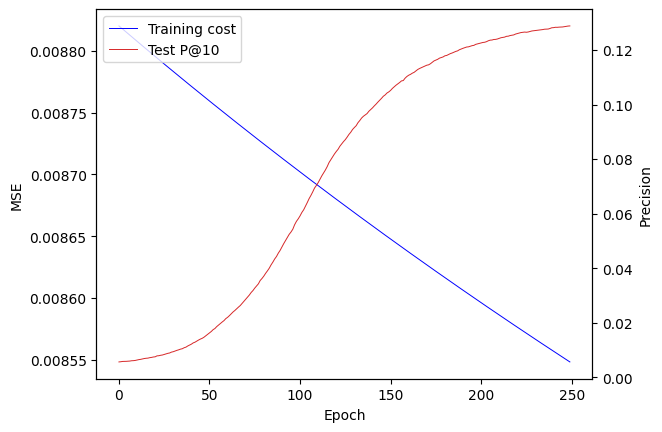

In [ ]:
import time, datetime

# For simplicity, we just train the model as we create the model object. And we keep the rating data as a variable
# in the model object.
class MF():
    def __init__(self, ratings, k=50, lrate=.01, nepochs=250, test_tracking=True):
        self.ratings = ratings
        self.test_tracking = test_tracking
        self.train(k, lrate, nepochs)
    
    # The scoring function.
    def predict(self):
        self.scores_ = scipy.special.expit((self.user_vec @ self.item_vec) / (np.mean(self.user_vec @ self.item_vec) * 2))
        return self.scores_
        # Your code here... (hint: can be done in 1 line).
        
        # Initialize the model parameters.
    def init(self, k):
        # Your code here...
        self.user_vec = np.random.normal(0.5, 0.1, (6040, k))
        self.item_vec = np.random.normal(0.5, 0.1, (k, 3706))

    # Train the model (learn the model parameters).
    def train(self, k, lrate, nepochs):
        start_time = time.time()
        self.init(k)
        self.train_errors, self.test_metrics = [], []

        # Training loop.
        for epoch in range(nepochs):
            # Gradient descent steps: model parameters' update.
            # Your code here... (hint: can be done in 3-4 lines).
            # JON: podemos usar BCE en lugar del error cuadrático medio
            err = np.multiply(self.predict(), self.ratings.train_mask) - self.ratings.train_matrix
            grad_users = np.sum(err, axis=1) / self.ratings.nusers
            grad_items = np.sum(err, axis=0) / self.ratings.nitems
            
            for i in range(k):
              self.user_vec[:,i] = self.user_vec[:,i] - lrate * grad_users
              self.item_vec[i,:] = self.item_vec[i,:] - lrate * grad_items

            # Produce training trace for inspection.
            train_error = (err**2).mean()
            self.train_errors.append(train_error)
            # We make precision tracking optional as it can be time-consuming.
            if self.test_tracking:
                test_metric = precision(self.scores(), self.ratings.test_matrix, 10)
                self.test_metrics.append(test_metric)
                trace(epoch, start_time, train_error, test_metric, 'P@10')
            else: trace(epoch, start_time, train_error)
        print()

        # If we're not tracking test metrics at least we report it at the end.
        if not self.test_tracking: trace(epoch, start_time, train_error, 
                                         precision(self.scores(), self.ratings.test_matrix, 10), 'P@10')

    # Warning: you don't need to use this function -- it's used only for computing precicion on test data.
    # Just remove from the prediction scores the matrix cells where there is a training rating: we assume
    # we don't want to recommend stuff the user has already rated, as is most often the case in recommender
    # system applications.
    def scores(self): return self.scores_ * (1 - ratings.train_mask)
        
# Create the model - this will directly trigger training.        
np.random.seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
mf = MF(ratings, lrate=.01, nepochs=250)

# Plot the training error and test metric trace.
plot(mf.train_errors, mf.test_metrics)
# print(mf.scores_)

Como se puede ver en la gráfica, la precisión obtenida no parece que vaya a mejorar más cuando pongamos un learning rate distinto o aumentemos el número de épocas, por lo que debe haber algún error previo, quizá en la actualización de los pesos o similar. También se puede observar que el error de entrenamiento que obtenemos nosotros es un orden de magnitud menor al obtenido por el profesor, por lo que seguramente se esté dando cierto overfitting.

De todas maneras, nos parece bastante curioso la curva de error obtenida por el profesor, ya que está está claramente dividida en dos partes. La primera parte, donde aumenta la precisión hasta aproximadamente 0.15, que es un valor cercano al que hemos obtenido nosotros. Y por otro lado, se puede ver como cuando aumenta el número de épocas, la precisión vuelve aumentar hasta casi duplicar el valor inicial después de haber pasado por un valle.

## 4.&nbsp; Factorización de matrices: modelo deep learning &ndash; opción a) TensorFlow

Reformulación de la factorización de matrices como caso particular "degenerado" de arquitectura neuronal.

### Ejercicio

Completar los huecos marcados con `# Your code here...`.

Observaciones: 
* Por la estructura de datos de entrenamiento que maneja TensorFlow, entrenar con toda la matriz de ratings (incluyendo todas las celdas sin dato) es demasiado costoso. Por ello se tomará una muestra pequeña de ejemlos negativos en cada época.
* En el esqueleto que aquí se proporciona, no se genera la traza (curva) de P@10 durante el entrenamiento ya que no encaja fácilmente en el API Keras de TensorFlow.

Model: "MF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 users (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 items (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 user_embeddings (Embedding)    (None, 50)           302000      ['users[0][0]']                  
                                                                                                  
 item_embeddings (Embedding)    (None, 50)           185300      ['items[0][0]']                  
                                                                                                 

0epoch [00:00, ?epoch/s]

Epoch 1/100
1/1 [==============================] - 19s 19s/step - loss: 1.3952
Epoch 2/100
1/1 [==============================] - 6s 6s/step - loss: 1.3341
Epoch 3/100
1/1 [==============================] - 6s 6s/step - loss: 1.2863
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 1.2460
Epoch 5/100
1/1 [==============================] - 6s 6s/step - loss: 1.2087
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 1.1728
Epoch 7/100
1/1 [==============================] - 7s 7s/step - loss: 1.1373
Epoch 8/100
1/1 [==============================] - 6s 6s/step - loss: 1.1019
Epoch 9/100
1/1 [==============================] - 7s 7s/step - loss: 1.0654
Epoch 10/100
1/1 [==============================] - 5s 5s/step - loss: 1.0272
Epoch 11/100
1/1 [==============================] - 7s 7s/step - loss: 0.9876
Epoch 12/100
1/1 [==============================] - 5s 5s/step - loss: 0.9466
Epoch 13/100
1/1 [==============================] - 6s 6s/step - loss: 

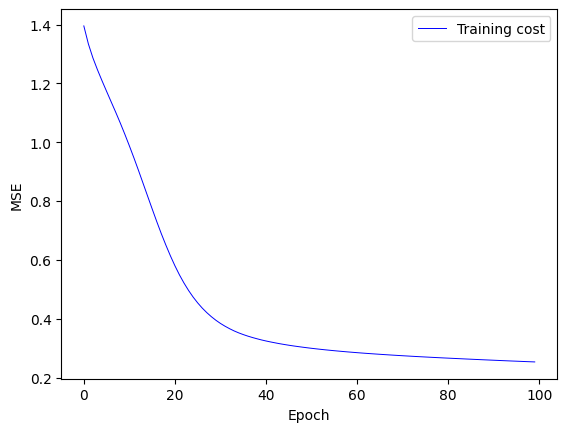

In [ ]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime, IPython

# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    users = tf.keras.layers.Input((), dtype=tf.int64, name='users')
    user_embeddings = tf.keras.layers.Embedding(
        input_dim=ratings.nusers,
        output_dim=k,
        name='user_embeddings') 
    items = tf.keras.layers.Input((), dtype=tf.int64, name='items')
    item_embeddings = tf.keras.layers.Embedding(
        input_dim=ratings.nitems,
        output_dim=k,
        name='item_embeddings')
    # TensorFlow has a built-in dot-product layer.
    dot = tf.keras.layers.Dot(1,normalize=False,name='Dot-prod')([user_embeddings(users), item_embeddings(items)]) 
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = tf.keras.Model(inputs=[users,items], outputs=dot, name="MF")

    # Compile the model: Adam optimizer is suggested here over SGD.
    # Your code here...
    tf_mf.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=lrate))

        
    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)
        
    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.
    
    hist = tf_mf.fit([users,items], rs, batch_size=batch_size, epochs=nepochs, callbacks=[TqdmCallback(verbose=0)]) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.        
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50, lrate=.01, nepochs=100)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100, 
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

De nuevo, no se obtienen los mismos resultados que el profesor, pero sí que se ha obtenido un error que va disminuyendo a medida aumentan las épocas.

## 5.&nbsp; Ampliación

### Ejercicio

Explorar variaciones sobre una o varias de las implementaciones anteriores, tales como:
* Diferentes funciones de scoring pérdida: sigmoide / BCE loss, BCE loss with logits.
* Diferentes optimizadores y configuraciones de los mismos (SGD, Adam, etc.).
* Variaciones en los hiperparámetros y configuración del modelo: learning rate, número de factores k, número de épocas, inicialización de parámetros del modelo, etc.
* Muestreo negativo: diferente número de ejemplos negativos.
* Añadir opciones tales como regularización, dropout, etc.
* Variaciones del modelo: términos de bias (usuario/item/global), ponderaciones de datos (p.e. ver modelo sencillo "*confidence weight*" de Hu, Koren & Volinsky), etc.
* Añadir capas ocultas en la implementación sobre framework de deep learning.
* Explorar una formulación *pairwise learning to rank* sobre MF (p.e. BPR).
* Probar otros modelos de factorización de matrices.

Idealmente estas variaciones buscan mejorar la precisión de la recomendación, pero se valorarán intentos interesantes aunque resulten fallidos en ese aspecto.

Usamos BCEWithLogitsLoss, que combina la sigmoide con BCELoss y tiene más estabilidad numérica. 

Model: "MF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 users (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 items (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 user_embeddings (Embedding)    (None, 50)           302000      ['users[0][0]']                  
                                                                                                  
 item_embeddings (Embedding)    (None, 50)           185300      ['items[0][0]']                  
                                                                                                 

0epoch [00:00, ?epoch/s]

Epoch 1/100
1/1 [==============================] - 13s 13s/step - loss: 0.6932
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 0.6931
Epoch 3/100
1/1 [==============================] - 6s 6s/step - loss: 0.6931
Epoch 4/100
1/1 [==============================] - 6s 6s/step - loss: 0.6931
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 0.6930
Epoch 6/100
1/1 [==============================] - 6s 6s/step - loss: 0.6930
Epoch 7/100
1/1 [==============================] - 5s 5s/step - loss: 0.6929
Epoch 8/100
1/1 [==============================] - 7s 7s/step - loss: 0.6929
Epoch 9/100
1/1 [==============================] - 6s 6s/step - loss: 0.6927
Epoch 10/100
1/1 [==============================] - 9s 9s/step - loss: 0.6926
Epoch 11/100
1/1 [==============================] - 6s 6s/step - loss: 0.6924
Epoch 12/100
1/1 [==============================] - 7s 7s/step - loss: 0.6920
Epoch 13/100
1/1 [==============================] - 6s 6s/step - loss: 

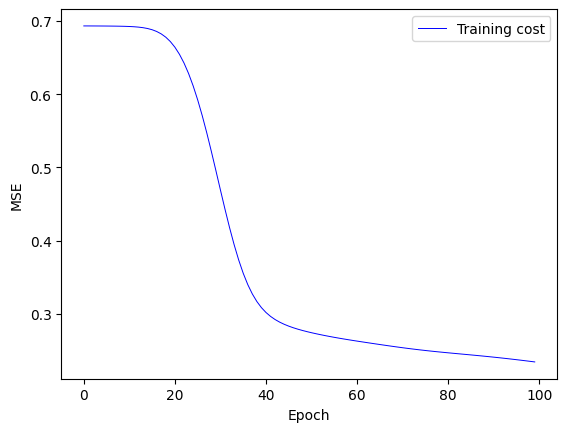

In [ ]:
# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    users = tf.keras.layers.Input((), dtype=tf.int64, name='users')
    user_embeddings = tf.keras.layers.Embedding(
        input_dim=ratings.nusers,
        output_dim=k,
        name='user_embeddings') 
    items = tf.keras.layers.Input((), dtype=tf.int64, name='items')
    item_embeddings = tf.keras.layers.Embedding(
        input_dim=ratings.nitems,
        output_dim=k,
        name='item_embeddings')
    # TensorFlow has a built-in dot-product layer.
    dot = tf.keras.layers.Dot(1,normalize=False,name='Dot-prod')([user_embeddings(users), item_embeddings(items)]) 
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = tf.keras.Model(inputs=[users,items], outputs=dot, name="MF")

    # Compile the model: Adam optimizer is suggested here over SGD.
    # Your code here...
    tf_mf.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=lrate))

        
    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)
        
    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.
    
    hist = tf_mf.fit([users,items], rs, batch_size=batch_size, epochs=nepochs, callbacks=[TqdmCallback(verbose=0)]) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.        
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50, lrate=.01, nepochs=100)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100, 
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

Como se puede observar, tras la implementación de BCEWithLogitsLoss en lugar de BCELoss, se ha obtenido un error inferior y una precisión superior a lo obtenido previamente, pese a que el tiempo de entrenamiento ha sido ligeramente superior. En la gráfica se puede observar como el error cuadrático medio desciende con el número de épocas, como para el caso anterior. 

El hecho de que haya necesitado algo más de tiempo de entrenamiento puede venir dado porque el método BCEWithLogitsLoss aplica la función sigmoide a los argumentos de la función.